# Setup

In [73]:
import json
from geopy.distance import geodesic
from datetime import datetime
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_file = "../dane/noon.txt"

In [78]:
class BusesStatistics():
    def __init__(self, data_file):
        self.data_file = data_file

        # Zbior najswierzszych danych autobusu
        self.buses_data = {}
        
        # Jakie busy przekroczyly 50 km/h
        self.fast_buses = set()

        # Wszystkie zmierzone predkosci (wielokrotnie dla tych samych autobusow) 
        # i punkty pomiarowe dla tych predkosci
        self.measured_speeds = []
        self.points = []

        # Zmierzone predkosci dla konkretnych autobusow
        self.speeds_per_bus = {}

        # Zmierzone predkosci dla konkretnych lini
        self.speeds_per_line = {}

        with open(data_file, 'r') as f:
            for line in tqdm(f):
                dct = json.loads(line)
                self._update_buses_data(dct)

    def get_fast_buses(self):
        return self.fast_buses
        
    def get_measured_speeds(self):
        return self.measured_speeds

    def get_speeds_per_bus(self):
        return self.speeds_per_bus

    def get_speeds_per_line(self):
        return self.speeds_per_line

    def get_points(self):
        return self.points


    def _time_diff(self, timestamp1, timestamp2):
        dt1 = datetime.strptime(timestamp1, "%Y-%m-%d %H:%M:%S")
        dt2 = datetime.strptime(timestamp2, "%Y-%m-%d %H:%M:%S")

        time_difference = dt2 - dt1
        difference_in_hours = time_difference.total_seconds() / 3600
        return difference_in_hours

    def _add_speed(self, av_speed, bus_id, line):
        if bus_id not in self.speeds_per_bus:
            self.speeds_per_bus[bus_id] = []
        if line not in self.speeds_per_line:
            self.speeds_per_line[line] = []

        self.measured_speeds.append(av_speed)
        self.speeds_per_bus[bus_id].append(av_speed)
        self.speeds_per_line[line].append(av_speed)
            
        if av_speed >= 50:
            self.fast_buses.add(bus_id)

    def _update_buses_data(self, bus_info: dict):
        bus_id     = bus_info["VehicleNumber"]
        time_stamp = bus_info["Time"]
        lon        = bus_info["Lon"]
        lat        = bus_info["Lat"]
        line       = bus_info["Lines"]
    
        if bus_id not in self.buses_data:
            self.buses_data[bus_id] = {
                "bus_id": bus_id,
                "time": time_stamp,
                "cords": (lat, lon)
            }
            return
        if self.buses_data[bus_id]["time"] == time_stamp:
            return
    
        distance_in_km = geodesic(self.buses_data[bus_id]["cords"], (lat, lon)).kilometers
        time_in_hours  = self._time_diff(self.buses_data[bus_id]["time"], time_stamp)

        av_speed = distance_in_km / time_in_hours

        self._add_speed(av_speed, bus_id, line)
        self.points.append(((lat, lon), self.buses_data[bus_id]["cords"]))

        self.buses_data[bus_id]["time"]  = time_stamp
        self.buses_data[bus_id]["cords"] = (lat, lon)


In [80]:
stats = BusesStatistics(data_file)
df = pd.DataFrame({
    'Speed': stats.get_measured_speeds(),
    'Points': stats.get_points()
})

485118it [00:27, 17918.05it/s]


# 1.1 Ile autobusów przkroczylo prędkość 50km/h?


In [61]:
print(len(stats.get_fast_buses()))

994


Między 12.00 a 13.00 994 autobusy przekroczyly 50km/h.

# Wiarygodnosc danych

todo

# 1.2 Gdzie autobusy przekraczaly prędkość
Upraszamy mapę miasta do siataki punków. 
Jeśli wykonaliśmy jakiś pomiar między punktami a i b, stawiamy pomiędzy nimi dodatkowe punkty. 
Teraz dla każdego postawionego punktu (wlacznie z a i b) szukamy najblizszego punktu siatki i zakladamy ze to w nim byl wykonany pomiar.

Jeśli w jakimś punkcie siatki conajmniej 20% pomiarów bylo wieksza niz 50km/h to oznaczamy go na mapie.

In [149]:
from scipy.spatial import cKDTree
import folium

grid_resolution = 0.001

def gen_middle_points(point1, point2, step_size):
    point1 = np.array(point1)
    point2 = np.array(point2)
    direction_vector = point2 - point1
    distance = np.linalg.norm(direction_vector)
    num_steps = int(distance / step_size)
    step_increments = np.arange(1, num_steps + 1) * step_size
    interpolated_points = point1 + (step_increments / distance)[:, np.newaxis] * direction_vector
    return interpolated_points

def prepare_points(df, bounds):
    all_points = []
    for (a, b), speed in zip(df['Points'], df['Speed']):
        all_points.append((a[0], a[1], speed))
        all_points.append((b[0], b[1], speed))
        mid_points = gen_middle_points(a, b, grid_resolution)
        for p in mid_points:
            all_points.append((p[0], p[1], speed))
            
    all_points = np.array(all_points)
    all_points = all_points[all_points[:, 2] <= 100][:]

    min_lat, min_lon = bounds[0]
    max_lat, max_lon = bounds[1]

    all_points = all_points[(all_points[:, 0] >= min_lat) & (all_points[:, 0] <= max_lat) &
                             (all_points[:, 1] >= min_lon) & (all_points[:, 1] <= max_lon)]
    return all_points


def make_map(df, bounds=[(52.0, 20.5), (52.5, 21.5)]):
    points = prepare_points(df, bounds)

    min_lat, min_lon = bounds[0]
    max_lat, max_lon = bounds[1]
    
    center_lat = (min_lat + max_lat) / 2
    center_lon = (min_lon + max_lon) / 2

    map = folium.Map(location=[center_lat, center_lon], zoom_start=10)
    map.fit_bounds(bounds)

    lon_range = np.arange(min_lon, max_lon, grid_resolution)
    lat_range = np.arange(min_lat, max_lat, grid_resolution)
    lon_grid, lat_grid = np.meshgrid(lon_range, lat_range)
    grid_points = np.column_stack((lat_grid.ravel(), lon_grid.ravel()))

    tree = cKDTree(grid_points)
    _, indices = tree.query(points[:, :2], k=1)

    all_count = np.zeros_like(grid_points[:, 0])
    fast_count = np.zeros_like(grid_points[:, 0])

    for (_, _, speed), i in zip(points, indices):
        all_count[i] += 1
        if speed >= 50:
            fast_count[i] += 1
            
    for (lat, lon), all, fast in tqdm(zip(grid_points, all_count, fast_count)):
        if all == 0:
            continue
        if fast / all >= 0.2:
            folium.CircleMarker(
                location=[lat, lon],
                radius=1,
                color='red',
                fill=True,
                fill_color='red'
            ).add_to(map)
    return map
    
make_map(df)

500000it [00:00, 879616.23it/s]


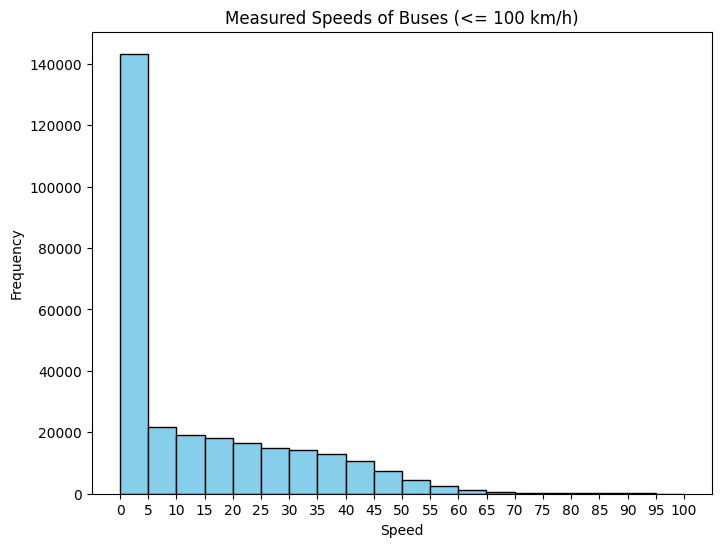

In [58]:
def gen_chart(speeds):
    plt.figure(figsize=(8, 6))
    plt.hist(speeds[speeds <= 100], bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('Speed')
    plt.ylabel('Frequency')
    plt.title('Measured Speeds of Buses (<= 100 km/h)')
    plt.xticks(np.arange(0, 101, 5))
    plt.show()

gen_chart(df['Speed'])

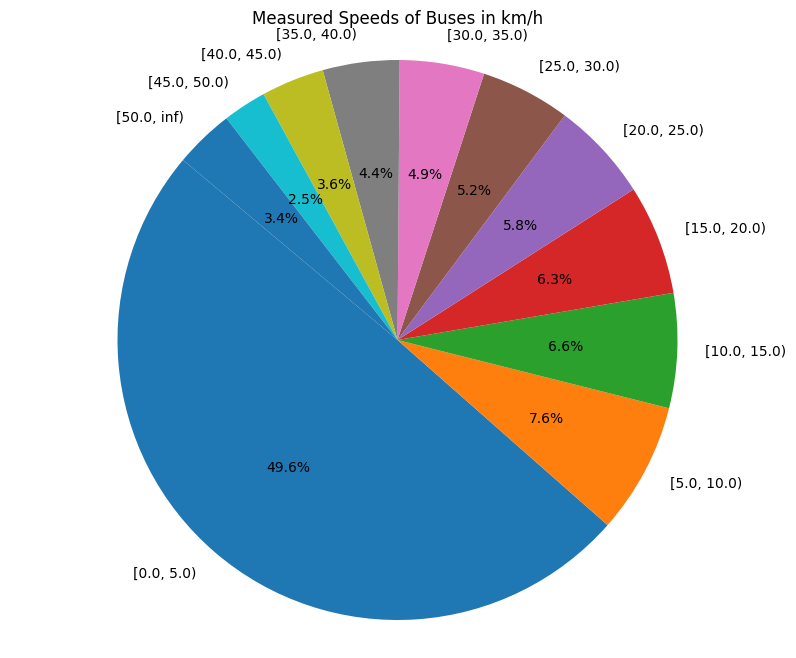

In [56]:
buckets = [i for i in range(0, 51, 5)] + [np.inf]
speed_buckets = pd.cut(df['Speed'], bins=buckets, right=False)
speed_counts = speed_buckets.value_counts().sort_index()

plt.figure(figsize=(10, 8))
plt.pie(speed_counts, labels=speed_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Measured Speeds of Buses in km/h')
plt.axis('equal') 
plt.show()